In [18]:
import pdb

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (confusion_matrix, 
                             precision_score, 
                             recall_score, 
                             accuracy_score, 
                             f1_score, 
                             roc_curve,
                             auc)

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

In [2]:
genres_df = pd.read_csv("../data/interum/top_genres.csv")
genres_df = genres_df[genres_df.Super_genre != "general"]
genres_df.drop(['Mode', "Key"], axis=1, inplace=True)

In [3]:
genres_df.head()

,Name,Danceability,Energy,Loudness,Speechness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,...,URL_features,Duration_ms,time_signature,Genre,Expanded_genre,artist_names,artist_ids,release_date,release_date_precision,Super_genre
0,YuveYuveYu,0.624,0.857,-6.250,0.0542,0.020800,0.206000,0.110,0.324,131.926,...,https://api.spotify.com/v1/audio-analysis/6J2V...,282920.0,4.0,celticmetal,celtic metal,The HU,0b2B3PwcYzQAhuJacmcYgc,2018-10-14,day,metal
1,Gloryhammer,0.517,0.916,-4.933,0.0559,0.000182,0.001910,0.306,0.444,135.996,...,https://api.spotify.com/v1/audio-analysis/4HA3...,300320.0,4.0,celticmetal,celtic metal,Gloryhammer,7dkEByOe0oHqc54qU4hwzV,2019-04-12,day,metal
2,Nostos,0.251,0.894,-4.103,0.0570,0.014400,0.000000,0.123,0.297,114.223,...,https://api.spotify.com/v1/audio-analysis/3W6X...,175353.0,4.0,celticmetal,celtic metal,"Orion's Reign,Minniva","3hRL14TJtJqr7i1IH3D1pU,50KIyycosYOGrBHfLaI1Ju",2018-10-05,day,metal
3,Yggdrasil,0.469,0.743,-5.570,0.0272,0.002220,0.000111,0.276,0.481,86.953,...,https://api.spotify.com/v1/audio-analysis/2gGv...,272292.0,4.0,celticmetal,celtic metal,Brothers of Metal,0WPCPYm5IDNtQjuJOGNPcy,2018-11-09,day,metal
4,Incense&Iron,0.487,0.952,-4.429,0.0613,0.000228,0.000000,0.161,0.329,125.993,...,https://api.spotify.com/v1/audio-analysis/1lRF...,237933.0,4.0,celticmetal,celtic metal,Powerwolf,5HFkc3t0HYETL4JeEbDB1v,2018-07-13,day,metal


In [4]:
super_genres = list(genres_df.Super_genre.unique())

In [5]:
def plot_genre_comparison(df, genre1, genre2, feature):
    subset = df[(df.Super_genre == genre1) | (df.Super_genre == genre2)]
    sns.scatterplot(x=feature, y="Super_genre", data=subset)
    plt.xlabel(feature)
    plt.ylabel("Genre")
    plt.title(f"{genre1} vs {genre2} - {feature}")
    plt.show()
    
    
# plot_genre_comparison(genres_df, "pop", "metal", "Energy")

In [6]:
def compare_genres(df, feature):
    for i in range(len(super_genres)):
        for j in range(i + 1, len(super_genres)):
            genre1 = super_genres[i]
            genre2 = super_genres[j]
            plot_genre_comparison(genres_df, genre1, genre2, feature)

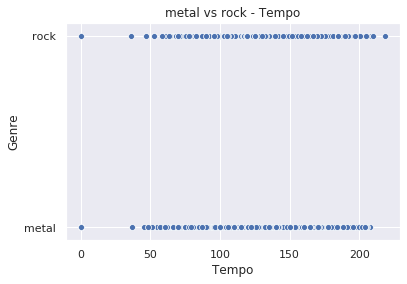

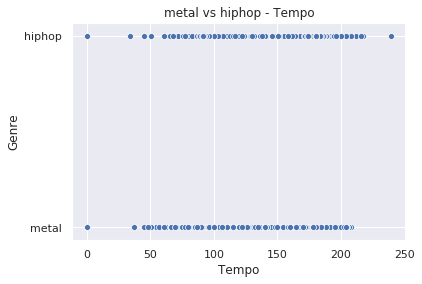

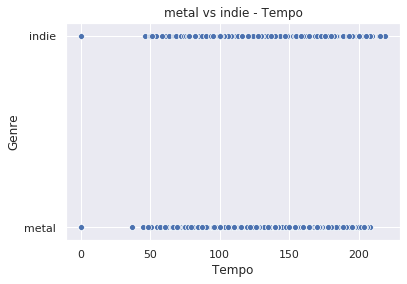

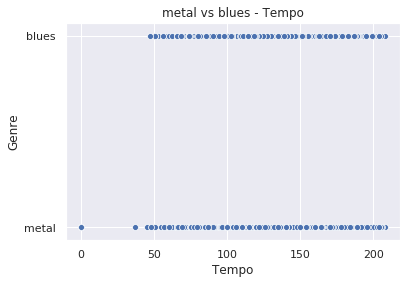

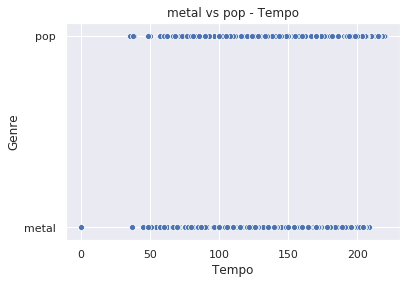

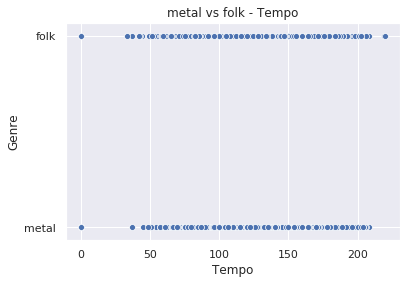

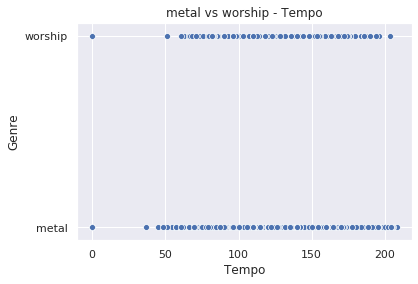

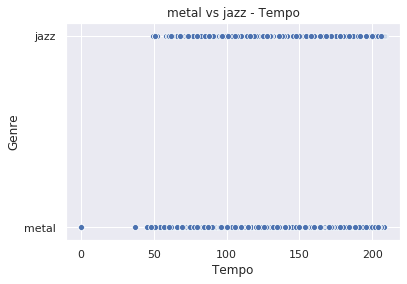

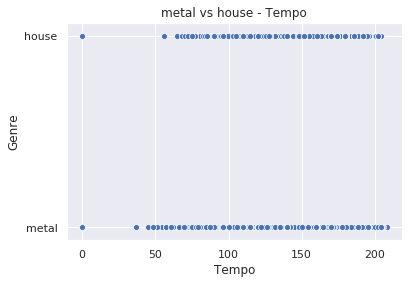

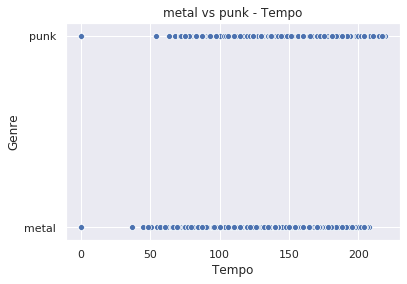

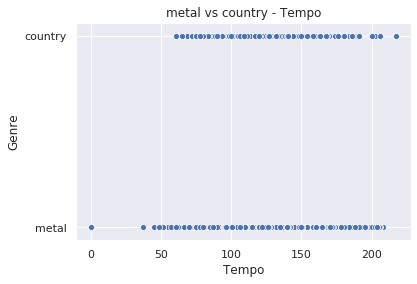

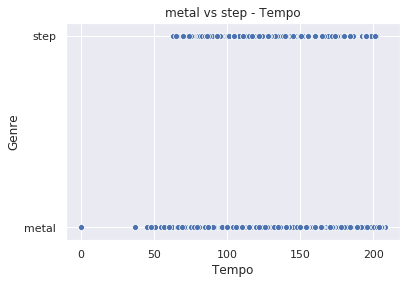

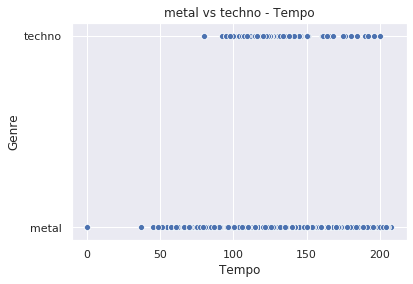

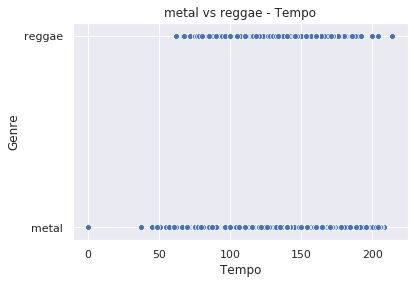

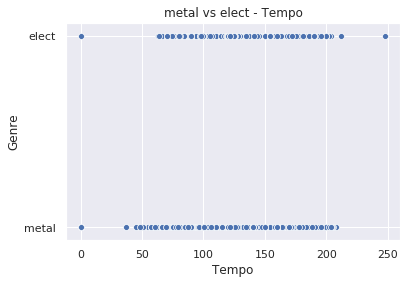

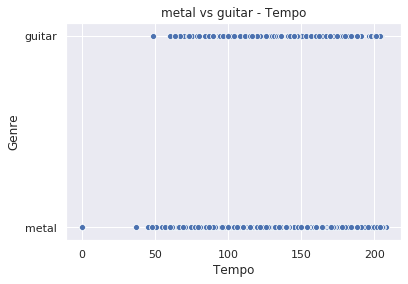

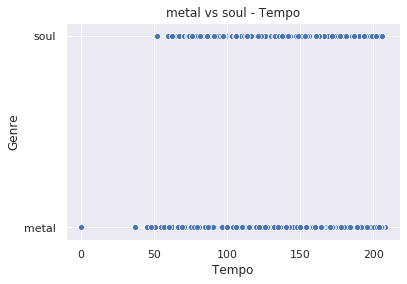

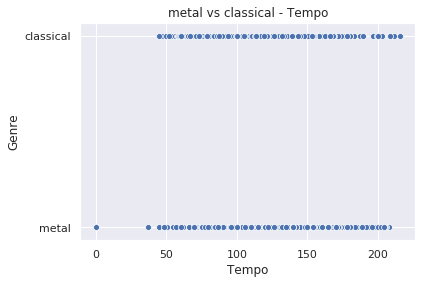

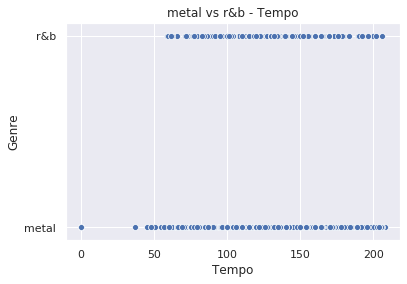

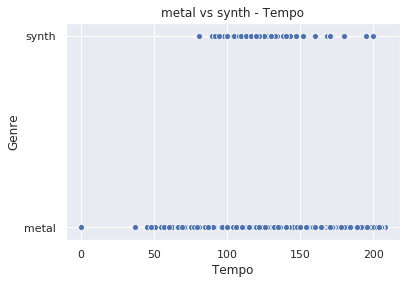

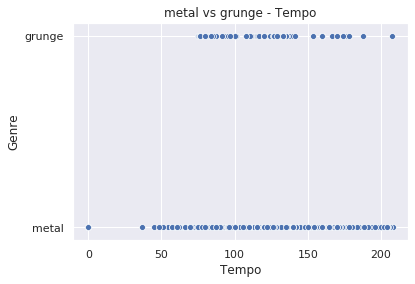

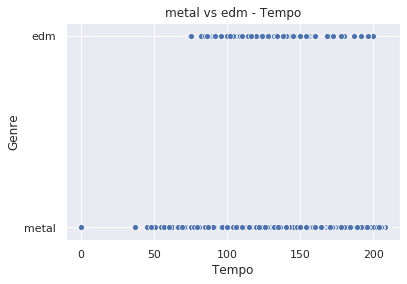

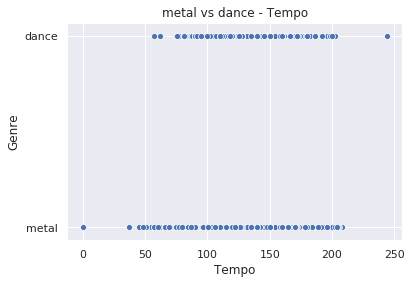

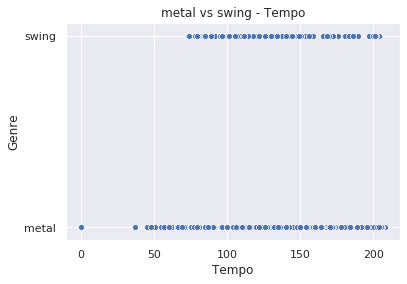

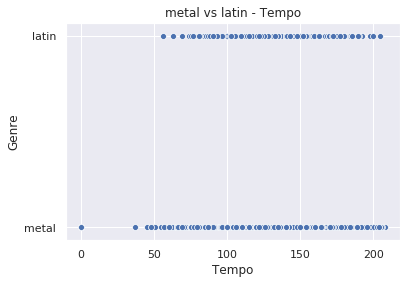

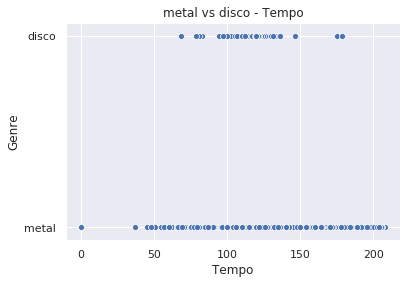

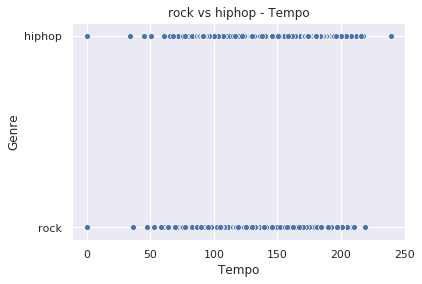

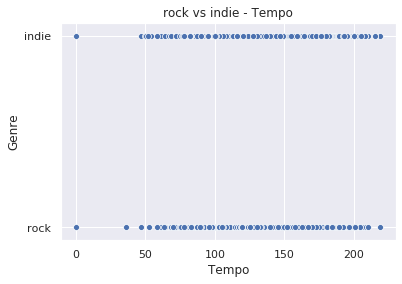

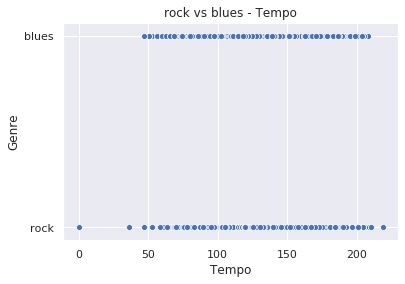

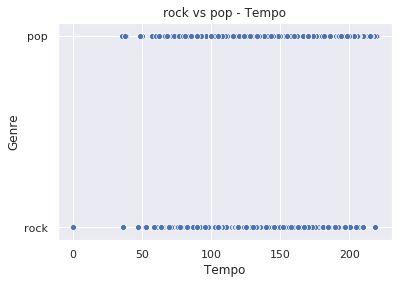

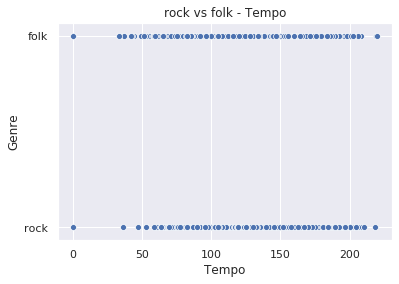

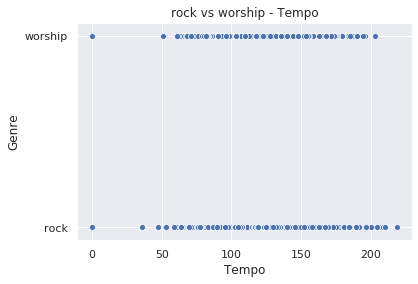

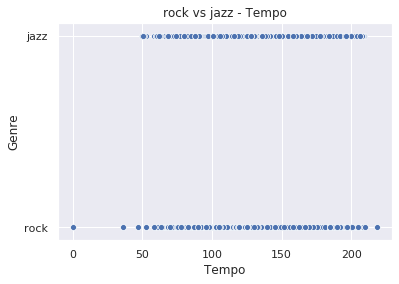

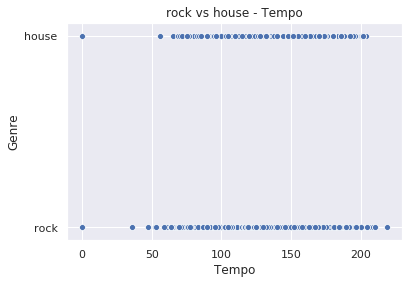

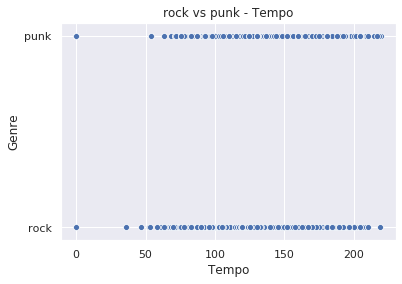

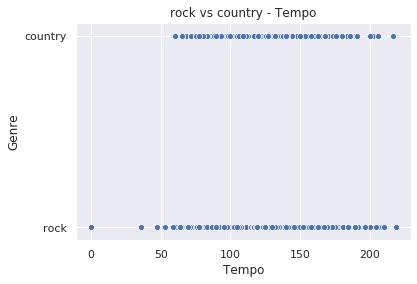

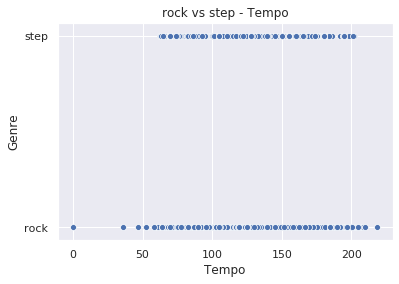

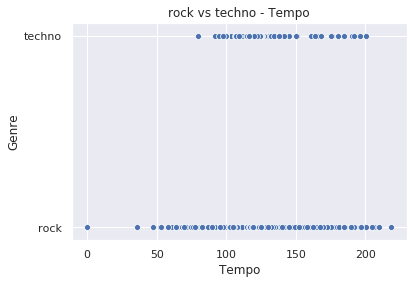

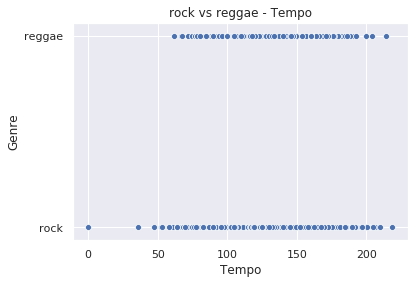

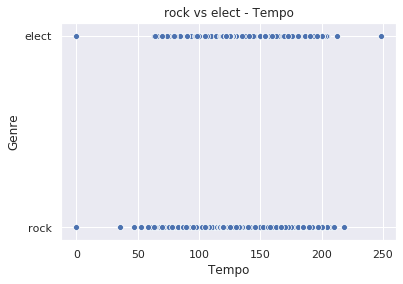

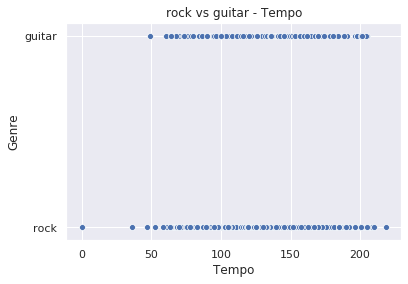

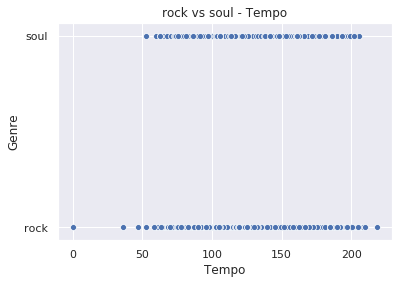

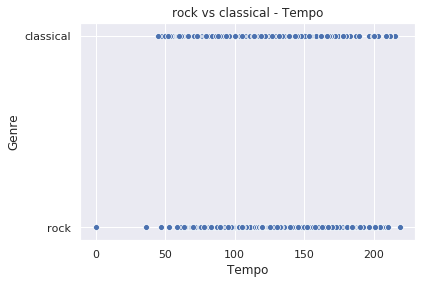

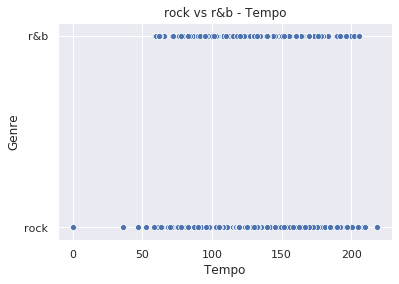

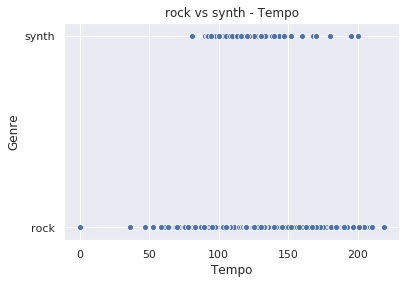

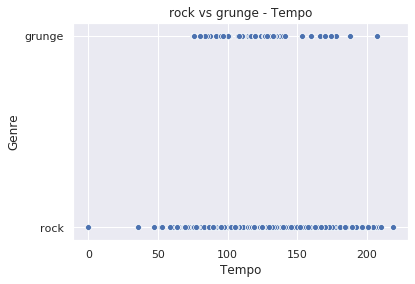

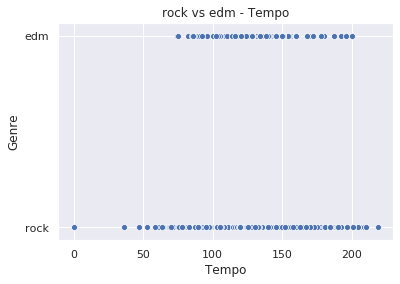

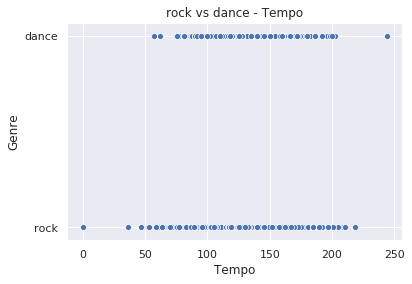

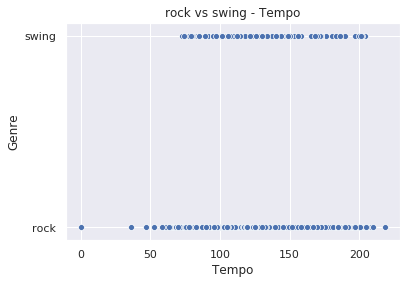

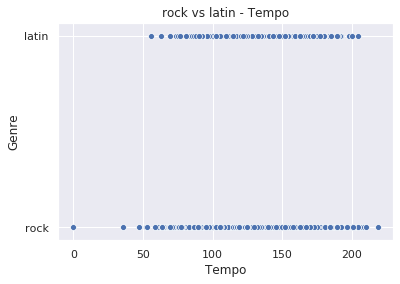

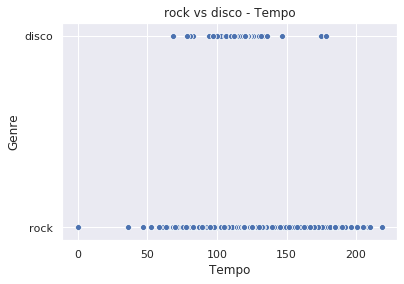

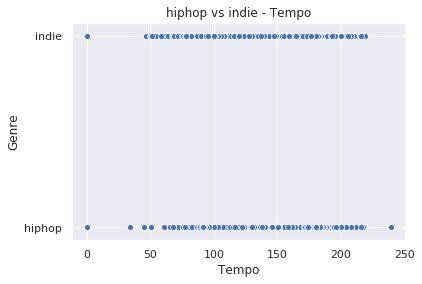

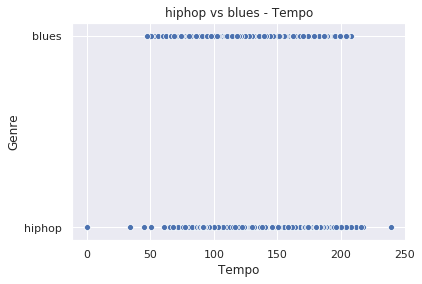

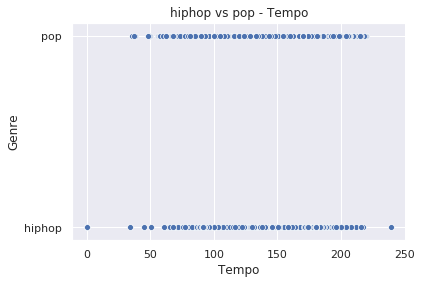

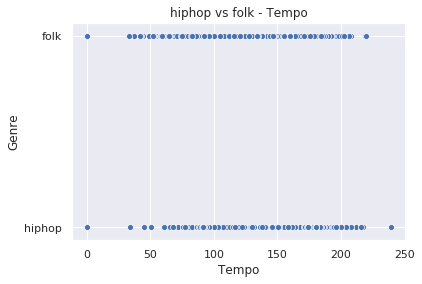

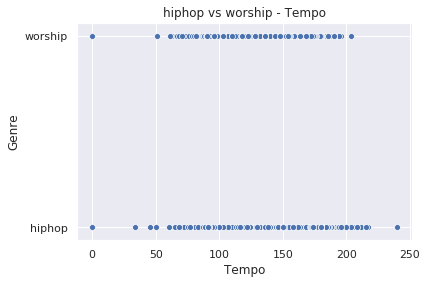

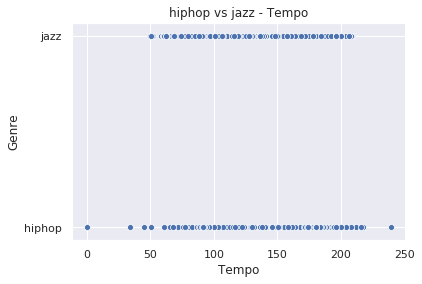

KeyboardInterrupt: 

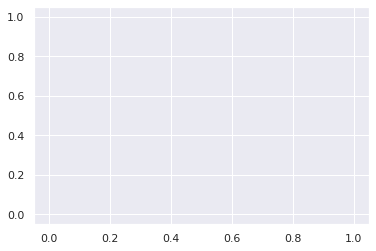

In [7]:
compare_genres(genres_df, "Tempo")

## Logistic Regression

In [8]:
genres_df.columns

Index(['Name', 'Danceability', 'Energy', 'Loudness', 'Speechness',
       'Acousticness', 'Instrumentalness', 'Liveness', 'Valence', 'Tempo',
       'Type', 'ID', 'Uri', 'Ref_Track', 'URL_features', 'Duration_ms',
       'time_signature', 'Genre', 'Expanded_genre', 'artist_names',
       'artist_ids', 'release_date', 'release_date_precision', 'Super_genre'],
      dtype='object')

In [32]:
def run_log_reg(df, genre1, genre2):
    
    subset = df[(df.Super_genre == genre1) | (df.Super_genre == genre2)]
    
    X = subset[['Danceability', 'Energy', 'Loudness', 'Speechness',
       'Acousticness', 'Instrumentalness', 'Liveness', 'Valence', 'Tempo',]]
    
    y = subset.Super_genre
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    logreg = LogisticRegression(fit_intercept=False)
    result = logreg.fit(X_train, y_train)
#     predictions = result.predict(X_test)
    
#     precision = precision_score(y, predictions, average=None)
#     recall = recall_score(y, predictions, average=None)
#     accuracy = accuracy_score(y, predictions)
#     f1 = f1_score(y, predictions, average=None)
#     print("PRECISION:\t", precision)
#     print("RECALL:\t\t", recall)
#     print("ACCURACY:\t", accuracy)
#     print("F1:\t\t", f1)

    target_scores = logreg.decision_function(X_test)
    
    fpr, tpr, thresholds = roc_curve(y_test, target_scores, pos_label=genre1) 
    
    AUC = auc(fpr, tpr)
    
#     sns.lineplot(fpr, tpr)
#     plt.xlabel("False Positive Rate")
#     plt.ylabel("True Positive Rate")
#     plt.show()
    
    return AUC, fpr, tpr


def generate_log_reg_table(df, genre_list):
    results = []
    for i in range(len(genre_list) - 1):
        for j in range(i + 1, len(genre_list)):
            genre1 = genre_list[i]
            genre2 = genre_list[j]
            
            AUC, fpr, tpr = run_log_reg(df, genre1, genre2)
            results.append((genre1, genre2, AUC, fpr, tpr))
    
    return pd.DataFrame(results, columns=["genre_1", "genre_2", "AUC", "fpr", "tpr"])

In [33]:
# run_log_reg(genres_df, "pop", "metal")
genre_aucs = generate_log_reg_table(genres_df, super_genres)


In [114]:
genre_aucs[genre_aucs.genre_1 == 'indie']

,genre_1,genre_2,AUC,fpr,tpr
75,indie,blues,0.691370,"[0.0, 0.0, 0.0, 0.0014903129657228018, 0.00149...","[0.0, 0.00035335689045936394, 0.00918727915194..."
76,indie,pop,0.414956,"[0.0, 0.0003770739064856712, 0.000377073906485...","[0.0, 0.0, 0.0007122507122507123, 0.0007122507..."
77,indie,folk,0.776515,"[0.0, 0.0, 0.0, 0.0006811989100817438, 0.00068...","[0.0, 0.0003562522265764161, 0.001425008906305..."
78,indie,worship,0.185548,"[0.0, 0.0, 0.006369426751592357, 0.00955414012...","[0.0, 0.0003495281370150297, 0.000349528137015..."
79,indie,jazz,0.166642,"[0.0, 0.0013089005235602095, 0.001308900523560...","[0.0, 0.0, 0.00035161744022503517, 0.000351617..."
80,indie,house,0.863780,"[0.0, 0.0, 0.0, 0.0012254901960784314, 0.00122...","[0.0, 0.00036010082823190496, 0.02268635217861..."
81,indie,punk,0.294713,"[0.0, 0.0009017132551848512, 0.000901713255184...","[0.0, 0.0, 0.00034928396786587494, 0.000349283..."
82,indie,country,0.746283,"[0.0, 0.0, 0.0, 0.0035335689045936395, 0.00353...","[0.0, 0.00035285815102328866, 0.00529287226534..."
83,indie,step,0.100680,"[0.0, 0.002257336343115124, 0.0361173814898419...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.000353982300884955..."
84,indie,techno,0.026822,"[0.0, 0.002173913043478261, 0.1304347826086956...","[0.0, 0.0, 0.0, 0.0003546099290780142, 0.00035..."


## Multinomial Logistic Regression

In [56]:
def get_genre_subset(df, genre_list):
    """
    Subsets a dataframe on multiple Super_genres
    """
    subset = df[df.Super_genre == genre_list[0]]
    for i in range(1, len(genre_list)):
        subset = pd.concat([subset, df[df.Super_genre == genre_list[i]]])
    
    return subset

In [127]:
def run_multinomial_log_reg(df, genre_list, solver="lbfgs"):
    """
    Runs a multinomial logistic regression on the provided target genres
    """
    subset = get_genre_subset(df, genre_list)
    
    X = subset[[
        'Danceability', 
        'Energy', 
#         'Loudness', 
        'Speechness',
        'Acousticness', 
        'Instrumentalness', 
        'Liveness', 
        'Valence', 
#         'Tempo'
               ]]
    y = subset.Super_genre
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)
    
    multi_logreg = LogisticRegression(random_state=42, solver=solver, multi_class="multinomial")
    multi_logreg.fit(X_train, y_train)
    
    return multi_logreg.score(X_test,y_test)

In [128]:
genres_df.Super_genre.value_counts().index

Index(['indie', 'pop', 'metal', 'rock', 'folk', 'hiphop', 'punk', 'jazz',
       'house', 'elect', 'blues', 'techno', 'step', 'worship', 'classical',
       'reggae', 'guitar', 'country', 'soul', 'dance', 'r&b', 'latin', 'edm',
       'swing', 'disco', 'synth', 'grunge'],
      dtype='object')

In [138]:
run_multinomial_log_reg(genres_df, ['indie', 'pop', 'metal', 'rock', 'folk', 'hiphop', 'punk', 'jazz',
       'house', 'elect', 'blues', 'techno', 'step', 'worship', 'classical',
       'reggae', 'guitar', 'country', 'soul', 'dance', 'r&b', 'latin', 'edm',
       'swing', 'disco', 'synth', 'grunge'], solver="saga")

0.296942898528627